<a href="https://colab.research.google.com/github/jacksonmcl/Federal_Funds_Rate_Model/blob/main/1b.%20New%20Data%20Extraction/new_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

dfs = {}

### Github Setup

In [232]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [233]:
!git -C "Federal_Funds_Rate_Model" pull || git clone https://github.com/jacksonmcl/Federal_Funds_Rate_Model.git "Federal_Funds_Rate_Model"

Already up to date.


# Helper Functions

In [234]:
# This function cleans a dataframe to change datetime to %Y-%m format
def df_dates_monthly(df, Date = 'Date'):
    clean_df = df.copy()
    clean_df[Date] = pd.to_datetime(clean_df[Date])
    clean_df[Date] = clean_df[Date].dt.strftime('%Y-%m')
    return clean_df

In [235]:
def df_change_percent(df, Value = 'Value'):
    clean_df = df.copy()
    clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
    clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
    return clean_df

In [236]:
def plot_comparison(base_df, comparison_df, base_label, comparison_label, Value='Value'):
    base_df = base_df.copy()
    comparison_df = comparison_df.copy()

    # Convert to Datetime
    base_df['Date'] = pd.to_datetime(base_df['Date'])
    base_date = base_df['Date']

    comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])
    comparison_date = comparison_df['Date']

    # Plot comparison metric
    plt.figure(figsize=(12, 6))
    plt.stackplot(base_df['Date'], base_df[Value], color='lightgray')
    #Pass the scaled DataFrame to sns.lineplot
    sns.lineplot(x='Date', y=Value, data=comparison_df, label=comparison_label, color='steelblue')

    # Customize plot
    plt.title(f'{base_label} and {comparison_label}')
    plt.xlabel('Date')
    plt.ylabel(f'{comparison_label}')
    plt.grid(True)
    plt.legend()
    plt.show()

In [237]:
def plot_scaled_comparison(base_df, comparison_df, base_label, comparison_label, Value='Value'):
    base_df = base_df.copy()
    comparison_df = comparison_df.copy()

    # Convert to Datetime
    base_df['Date'] = pd.to_datetime(base_df['Date'])
    base_date = base_df['Date']

    comparison_df['Date'] = pd.to_datetime(comparison_df['Date'])
    comparison_date = comparison_df['Date']

    # Scale Data
    scaler = MinMaxScaler(feature_range=(0, 1))

    #Scale only the 'Value' column and keep it as a Series
    base_scaled_values = scaler.fit_transform(base_df[['Value']])[:, 0]
    comparison_scaled_values = scaler.fit_transform(comparison_df[['Value']])[:, 0]

    # Create new DataFrames with scaled values and original 'Date'
    scaled_base_df = pd.DataFrame({'Date': base_date, Value: base_scaled_values})
    scaled_comparison_df = pd.DataFrame({'Date': comparison_date, Value: comparison_scaled_values})


    # Plot comparison metric
    plt.figure(figsize=(12, 6))
    plt.stackplot(scaled_base_df['Date'], scaled_base_df[Value], color='lightgray')
    #Pass the scaled DataFrame to sns.lineplot
    sns.lineplot(x='Date', y=Value, data=scaled_comparison_df, label=comparison_label, color='steelblue')

    # Customize plot
    plt.title(f'{base_label} and {comparison_label} (Scaled)')
    plt.xlabel('Date')
    plt.ylabel(f'{comparison_label}(Scaled)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Data Extraction

## Key Features

### Federal Funds Rate
The federal funds rate is the interest rate at which depository institutions (mainly banks) lend reserve balances to other depository institutions overnight on an uncollateralized basis. In simpler terms, it's the rate banks charge each other for short-term loans to meet their reserve requirements.

In [238]:
dfs['Federal_Funds_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/1. Data Extraction/FEDFUNDS.csv')
dfs['Federal_Funds_Rate'].head()
ffr_data = dfs['Federal_Funds_Rate'].copy()

In [239]:
dfs['Federal_Funds_Rate'].shape

(845, 2)

In [240]:
# Create a copy of the dataset for our lagged Federal Funds Rate predictor
dfs['Lagged_FFR'] = dfs['Federal_Funds_Rate'].copy()
dfs['Lagged_FFR']['observation_date'] = pd.to_datetime(dfs['Lagged_FFR']['observation_date'], format='%Y-%m-%d')

# Move all dates by 1 month ahead of time
dfs['Lagged_FFR']['observation_date'] = dfs['Lagged_FFR']['observation_date'] + pd.DateOffset(months=1)

### Reserve Rate
The interest on reserve balances (IORB) rate is the interest rate that the Federal Reserve pays to eligible institutions for the balances they keep in master accounts at Federal Reserve Banks. The IORB rate is a key tool of monetary policy and is set by the Board of Governors.

In [241]:
dfs['Reserve_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/1. Data Extraction/IOER.csv')
dfs['Reserve_Rate'].head()

,observation_date,IOER
0,2008-10-09,0.75
1,2008-10-10,0.75
2,2008-10-11,0.75
3,2008-10-12,0.75
4,2008-10-13,0.75


In [242]:
dfs['Reserve_Rate'].shape

(4676, 2)

### Discount Rate
The discount rate is the interest rate the Federal Reserve charges commercial banks and other financial institutions for short-term loans. The discount rate is applied at the Fed's lending facility, which is called the discount window.

In [243]:
dfs['Discount_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/1. Data Extraction/INTDSRUSM193N.csv')
dfs['Discount_Rate'].head()

,observation_date,INTDSRUSM193N
0,1950-01-01,1.5
1,1950-02-01,1.5
2,1950-03-01,1.5
3,1950-04-01,1.5
4,1950-05-01,1.5


In [244]:
dfs['Discount_Rate'].shape

(860, 2)

In [245]:
# Create a copy of the dataset for our lagged Federal Funds Rate predictor
dfs['Lagged_DR'] = dfs['Discount_Rate'].copy()
dfs['Lagged_DR']['observation_date'] = pd.to_datetime(dfs['Lagged_DR']['observation_date'], format='%Y-%m-%d')

# Move all dates by 1 month ahead of time
dfs['Lagged_DR']['observation_date'] = dfs['Lagged_DR']['observation_date'] + pd.DateOffset(months=1)

### Bank Prime Loan Rate
The prime interest rate is the percentage that U.S. commercial banks charge their most creditworthy customers for loans. Like all loan rates, the prime interest rate is derived from the federal funds' overnight rate, set by the Federal Reserve at meetings held eight times a year. The prime interest rate is the benchmark banks and other lenders use when setting their interest rates for every category of loan from credit cards to car loans and mortgages.

In [246]:
dfs['Prime_Loan_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/1. Data Extraction/DPRIME.csv')
dfs['Prime_Loan_Rate'].head()

,observation_date,DPRIME
0,1955-08-04,3.25
1,1955-08-05,3.25
2,1955-08-08,3.25
3,1955-08-09,3.25
4,1955-08-10,3.25


In [247]:
dfs['Prime_Loan_Rate'].shape

(18102, 2)

In [248]:
# Create a copy of the dataset for our lagged Federal Funds Rate predictor
dfs['Lagged_PR'] = dfs['Prime_Loan_Rate'].copy()
dfs['Lagged_PR']['observation_date'] = pd.to_datetime(dfs['Lagged_PR']['observation_date'], format='%Y-%m-%d')

# Move all dates by 1 month ahead of time
dfs['Lagged_PR']['observation_date'] = dfs['Lagged_PR']['observation_date'] + pd.DateOffset(months=1)

## Experimental Features

### Total Construction Spending
The amount of construction spending in the United States. This is a strong economic indicator because construction spending increases when consumers are confident in the growth of the economy.  

In [249]:
dfs['Struct_Spending'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/TRESEGUSM052N.csv')
dfs['Struct_Spending'].head()

,observation_date,TRESEGUSM052N
0,1950-12-01,1445.5
1,1951-01-01,NaN
2,1951-02-01,NaN
3,1951-03-01,NaN
4,1951-04-01,NaN


In [250]:
dfs['Struct_Spending'].shape

(889, 2)

### The ​CBOE Volatility Index (VIX)
 A measurement of “market expectations of near-term volatility conveyed by stock index option prices”. The VIX gives guidance to market expectations, as if there is a period of high volatility, the direction of the markets is uncertain. Periods of uncertainty tend to lead to lower consumer confidence in the economy.

In [251]:
dfs['Volatility_Idx'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/VIXCLS.csv')
dfs['Volatility_Idx'].head()

,observation_date,VIXCLS
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [252]:
dfs['Volatility_Idx'].shape

(9158, 2)

### Total Reserves Except Gold on the Balance Sheet
​It represents the size of the central banks liabilities.

In [253]:
dfs['Reserves_Ex_Gold'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/TTLCONS.csv')
dfs['Reserves_Ex_Gold'].head()

,observation_date,TTLCONS
0,1993-01-01,458080
1,1993-02-01,462967
2,1993-03-01,458399
3,1993-04-01,469425
4,1993-05-01,468998


In [254]:
dfs['Reserves_Ex_Gold'].shape

(384, 2)

### Moody’s Seasoned AAA Corporate Bond Yield​
The interest rate that triple-A rated bonds will pay investors. This variable has a unique relationship with the dependent variable in this model. This is because as the effective federal funds rate decreases, investors will flock toward triple-A rated bonds because they should offer a higher rate of return than treasuries. However, lowering the effective federal funds rate could also cause a decrease in the corporate bond yield over a longer time period.  

In [255]:
dfs['AAA_Bond_Yield'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/AAA.csv')
dfs['AAA_Bond_Yield'].head()

,observation_date,AAA
0,1919-01-01,5.35
1,1919-02-01,5.35
2,1919-03-01,5.39
3,1919-04-01,5.44
4,1919-05-01,5.39


### Conference Board US Manufacturers New Orders Nondefense Capital Good Ex Aircraft​
A measurement conducted by the U.S. Census Bureau. In the Tech Bubble burst and
the Housing Market crash this variable decreased sharply. Typically during times of economic contraction, manufactured orders fall.  

In [256]:
dfs['New_Orders'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/NEWORDER.csv')
dfs['New_Orders'].head()

,observation_date,NEWORDER
0,1992-02-01,33857
1,1992-03-01,35258
2,1992-04-01,35992
3,1992-05-01,36811
4,1992-06-01,36666


### 30-Year Fixed Rate Mortgage Average
The term fixed-rate mortgage refers to a home loan that has a fixed interest rate for the entire term of the loan. This means that the mortgage carries a constant interest rate from beginning to end. Fixed-rate mortgages are popular products for consumers who want to know how much they have to pay every month. Fixed-rate mortgages may be open or closed with specific terms of 15 or 30 years or they may run for a length of time agreed upon by the lender and borrower.

In [257]:
dfs['Mortgage_Rate'] = pd.read_csv('Federal_Funds_Rate_Model/1. Data Extraction/MORTGAGE30US.csv')
dfs['Mortgage_Rate'].head()

,observation_date,MORTGAGE30US
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [258]:
dfs['Mortgage_Rate'].shape

(2806, 2)

###  M2 money supply​
Consists of savings deposits plus small-denomination time deposits along with balanced in money market mutual funds.  

In [259]:
dfs['M2_Supply'] = pd.read_csv('Federal_Funds_Rate_Model/1b. New Data Extraction/M2SL.csv')
dfs['M2_Supply'].head()

,observation_date,M2SL
0,1959-01-01,286.6
1,1959-02-01,287.7
2,1959-03-01,289.2
3,1959-04-01,290.1
4,1959-05-01,292.2


In [260]:
dfs['M2_Supply'].shape

(792, 2)

# Data Cleaning

In [261]:
# Standarize Data
clean_dfs = {}
target_start = min(dfs['Federal_Funds_Rate']['observation_date'])
target_end = max(dfs['Federal_Funds_Rate']['observation_date'])

for label, df in dfs.items():
  clean_df = df.copy()
  clean_df.columns = ['Date', 'Value']
  clean_df = clean_df[clean_df['Date'] >= target_start]
  clean_df = clean_df[clean_df['Date'] <= target_end]
  clean_dfs[label] = clean_df

ffr_data = clean_dfs['Federal_Funds_Rate']

# Graph Visualizations

## Target Comparison (Value)

Federal_Funds_Rate
         Date  Value
0  1954-07-01   0.80
1  1954-08-01   1.22
2  1954-09-01   1.07
3  1954-10-01   0.85
4  1954-11-01   0.83


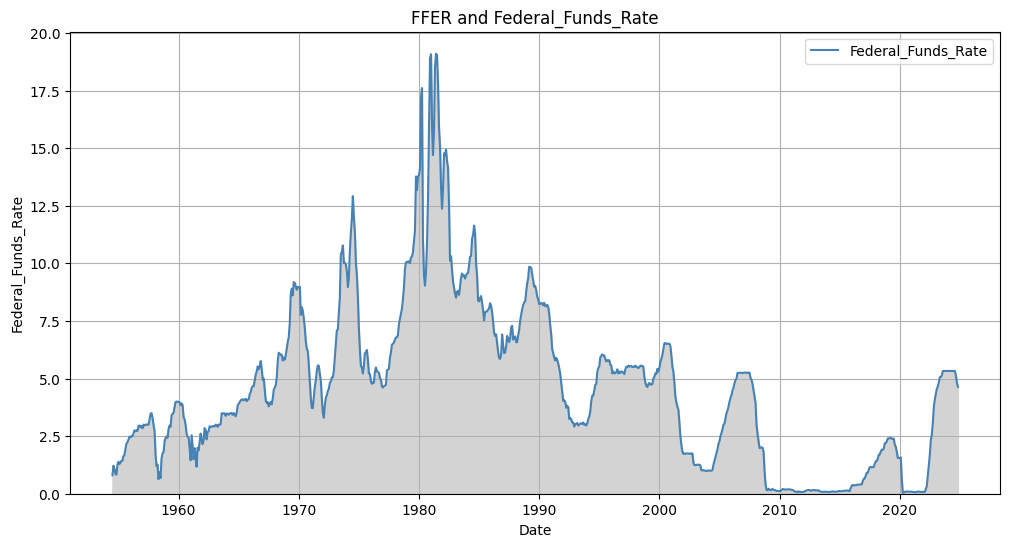

Lagged_FFR
        Date  Value
0 1954-08-01   0.80
1 1954-09-01   1.22
2 1954-10-01   1.07
3 1954-11-01   0.85
4 1954-12-01   0.83


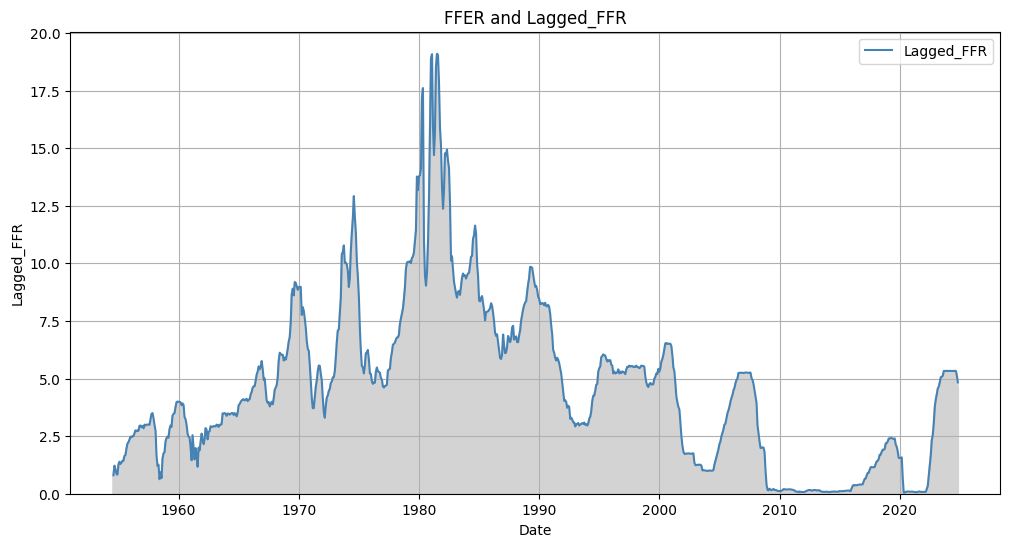

Reserve_Rate
         Date  Value
0  2008-10-09   0.75
1  2008-10-10   0.75
2  2008-10-11   0.75
3  2008-10-12   0.75
4  2008-10-13   0.75


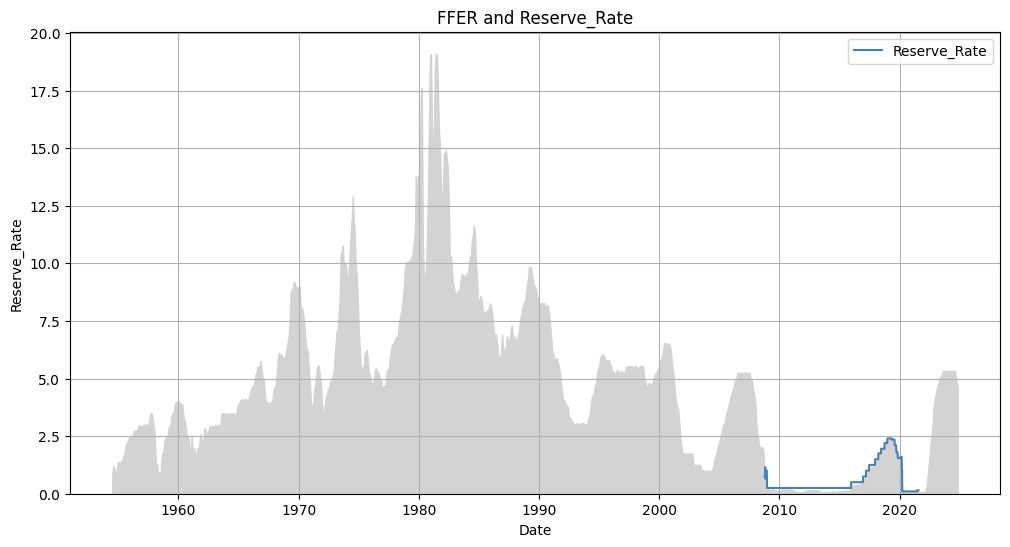

Discount_Rate
          Date  Value
54  1954-07-01    1.5
55  1954-08-01    1.5
56  1954-09-01    1.5
57  1954-10-01    1.5
58  1954-11-01    1.5


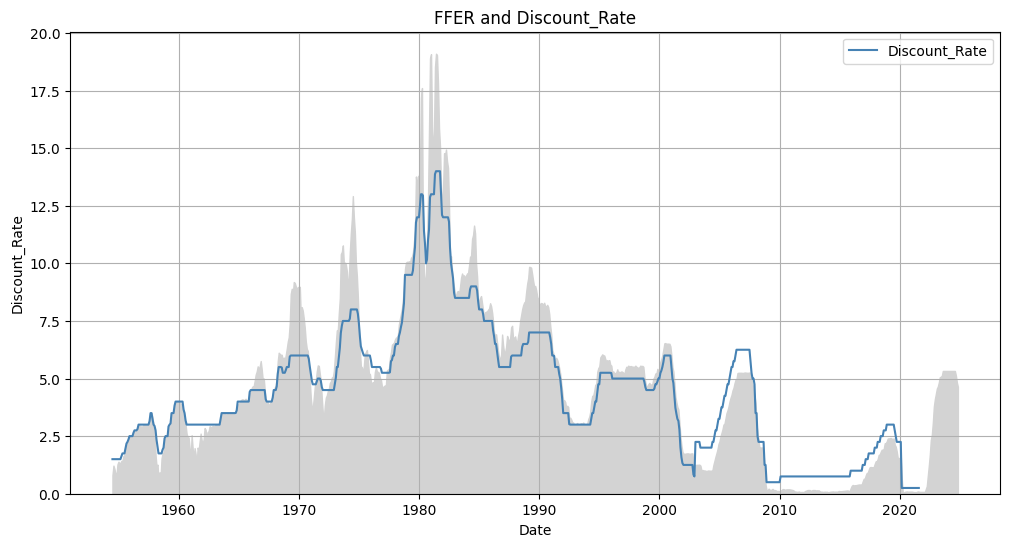

Lagged_DR
         Date  Value
53 1954-07-01    1.5
54 1954-08-01    1.5
55 1954-09-01    1.5
56 1954-10-01    1.5
57 1954-11-01    1.5


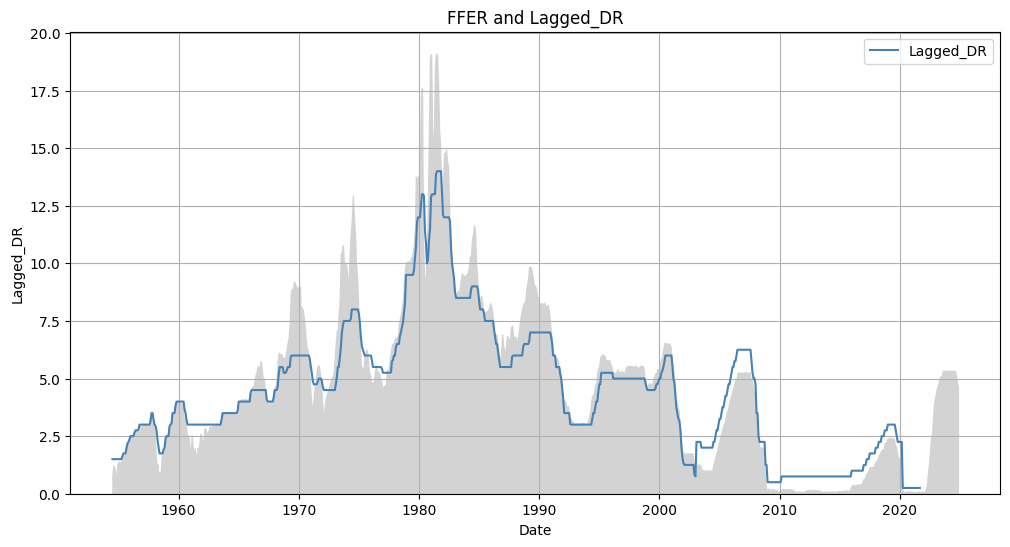

Prime_Loan_Rate
         Date  Value
0  1955-08-04   3.25
1  1955-08-05   3.25
2  1955-08-08   3.25
3  1955-08-09   3.25
4  1955-08-10   3.25


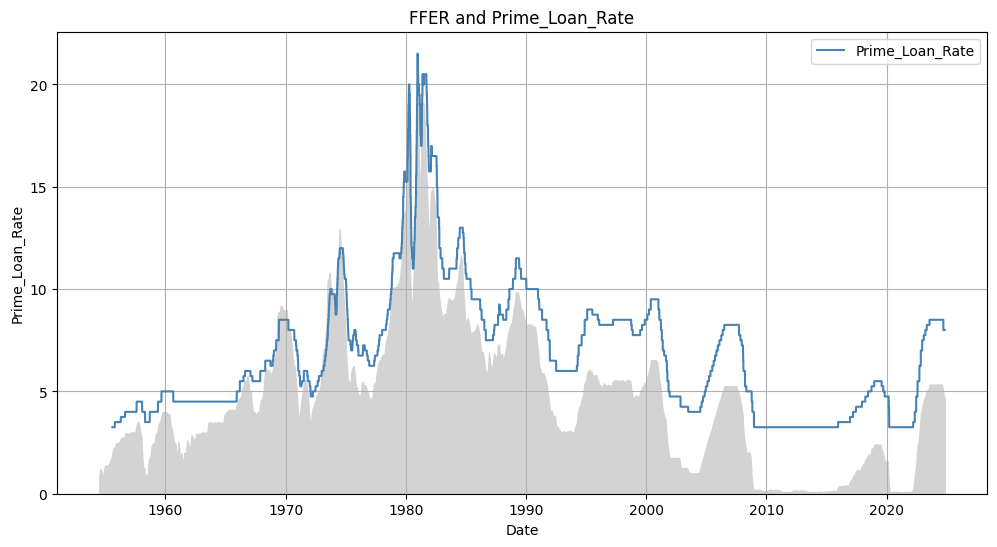

Lagged_PR
        Date  Value
0 1955-09-04   3.25
1 1955-09-05   3.25
2 1955-09-08   3.25
3 1955-09-09   3.25
4 1955-09-10   3.25


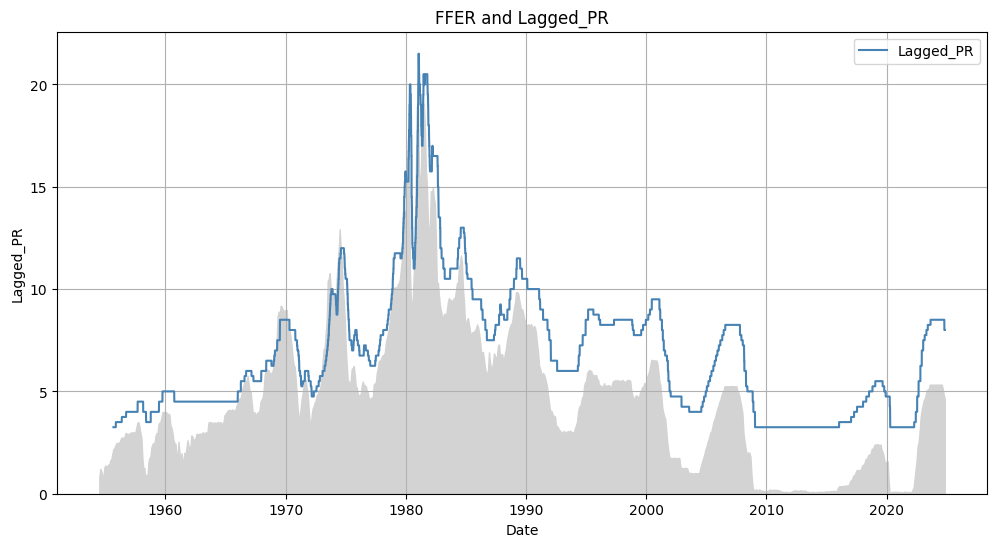

Struct_Spending
          Date  Value
43  1954-07-01    NaN
44  1954-08-01    NaN
45  1954-09-01    NaN
46  1954-10-01    NaN
47  1954-11-01    NaN


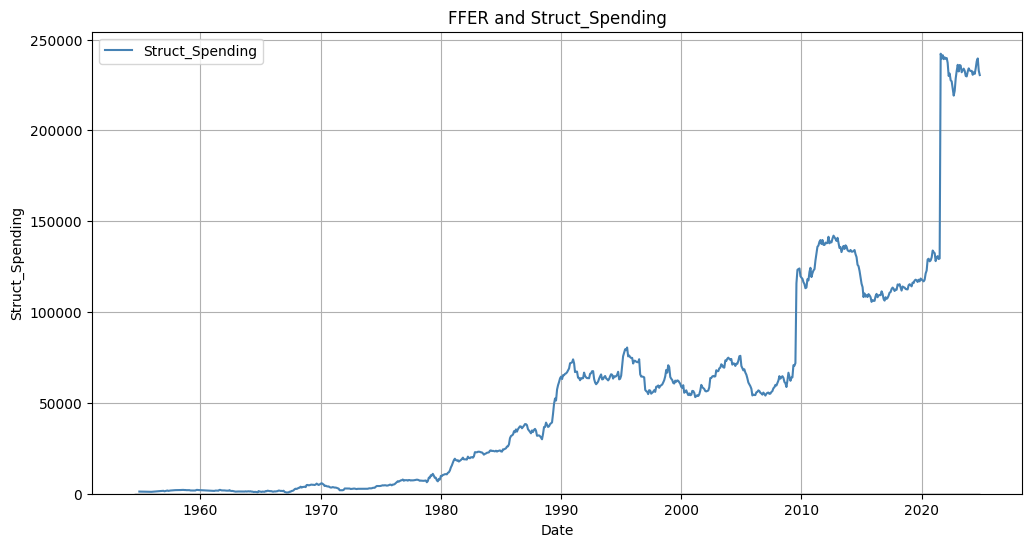

Volatility_Idx
         Date  Value
0  1990-01-02  17.24
1  1990-01-03  18.19
2  1990-01-04  19.22
3  1990-01-05  20.11
4  1990-01-08  20.26


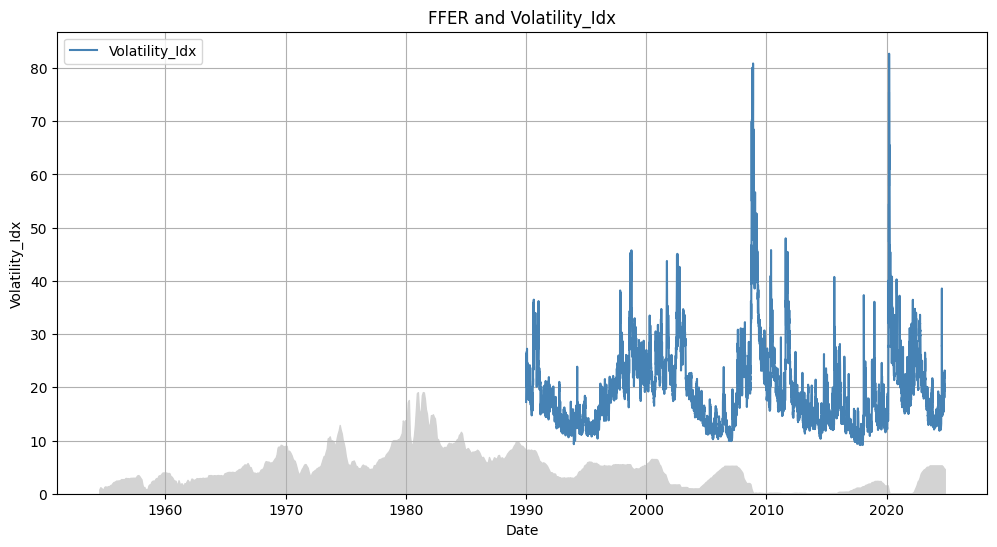

Reserves_Ex_Gold
         Date   Value
0  1993-01-01  458080
1  1993-02-01  462967
2  1993-03-01  458399
3  1993-04-01  469425
4  1993-05-01  468998


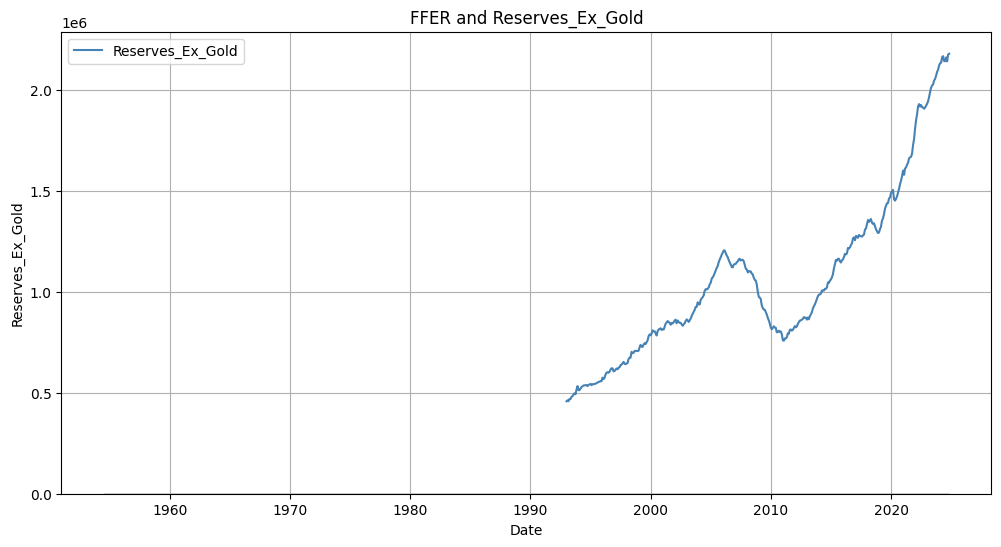

AAA_Bond_Yield
           Date  Value
426  1954-07-01   2.89
427  1954-08-01   2.87
428  1954-09-01   2.89
429  1954-10-01   2.87
430  1954-11-01   2.89


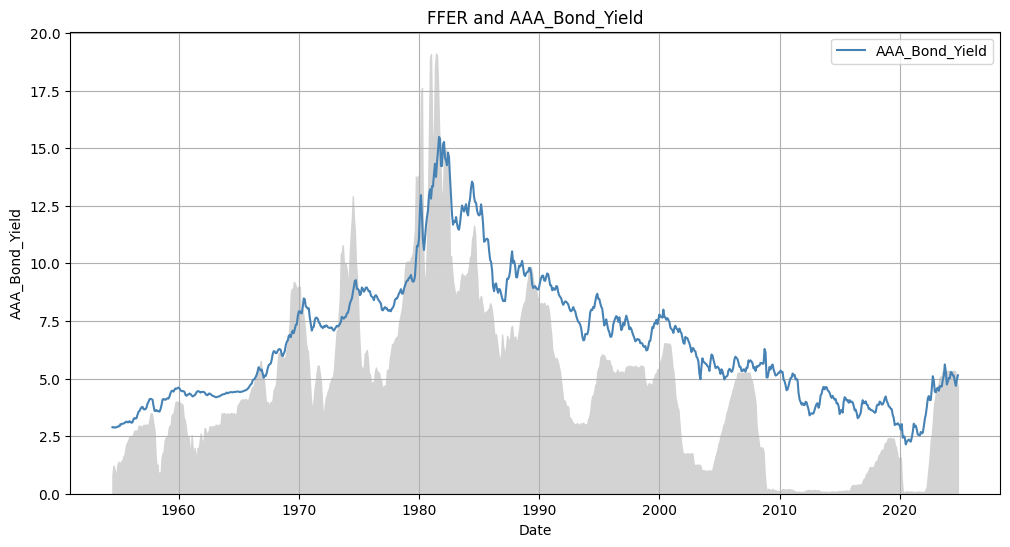

New_Orders
         Date  Value
0  1992-02-01  33857
1  1992-03-01  35258
2  1992-04-01  35992
3  1992-05-01  36811
4  1992-06-01  36666


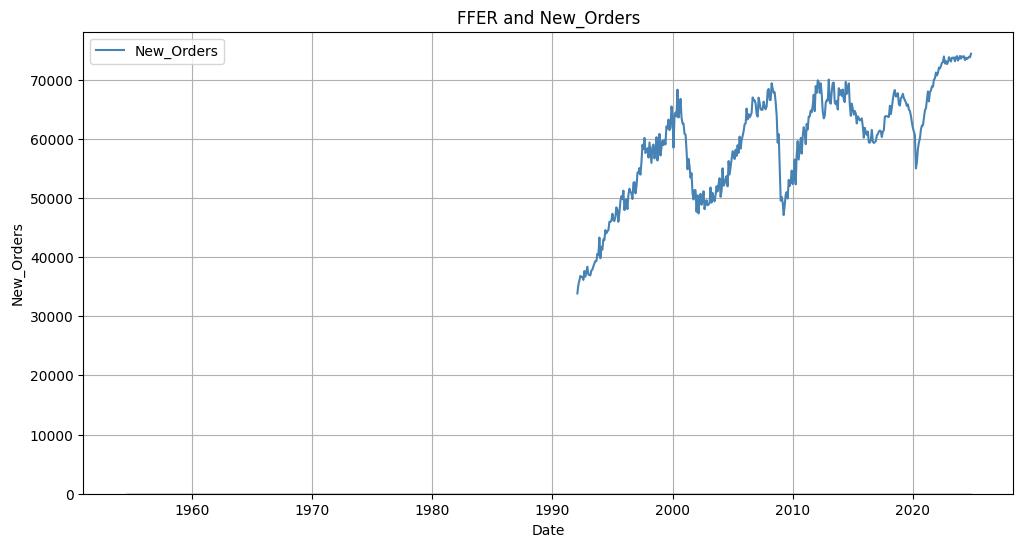

Mortgage_Rate
         Date  Value
0  1971-04-02   7.33
1  1971-04-09   7.31
2  1971-04-16   7.31
3  1971-04-23   7.31
4  1971-04-30   7.29


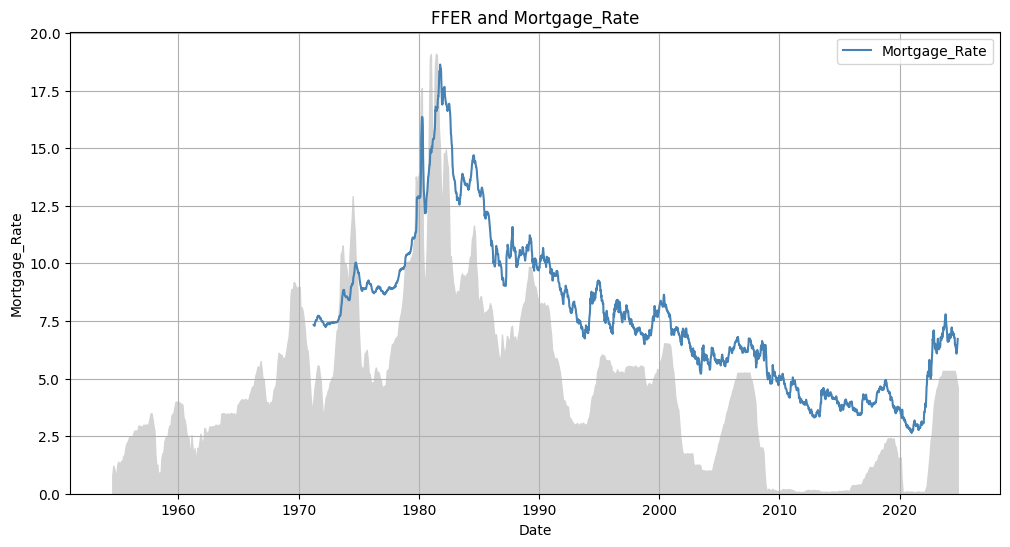

M2_Supply
         Date  Value
0  1959-01-01  286.6
1  1959-02-01  287.7
2  1959-03-01  289.2
3  1959-04-01  290.1
4  1959-05-01  292.2


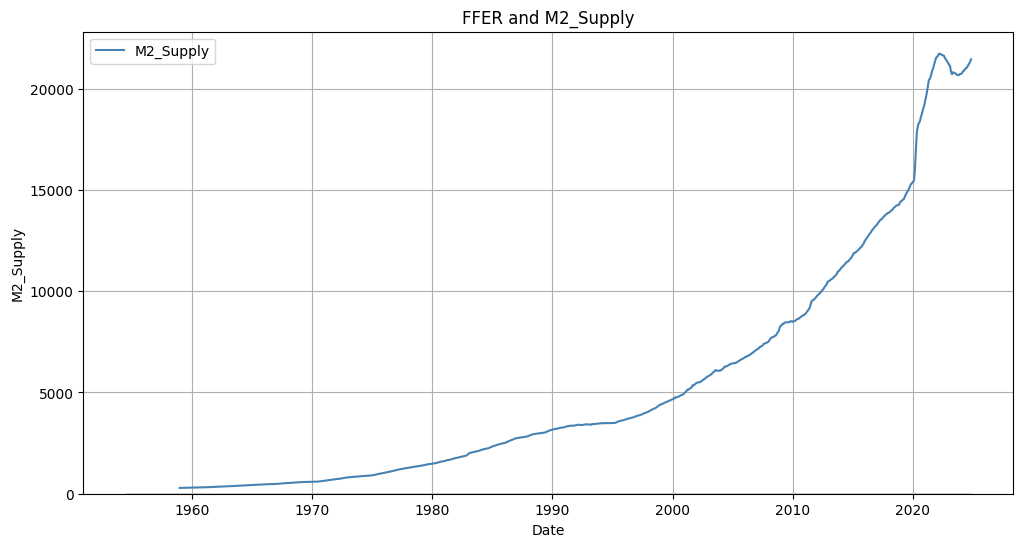

In [262]:
for label, df in clean_dfs.items():
  print(label)
  print(df.head())
  plot_comparison(ffr_data, df, 'FFER', label)


## Target Comparison (Value-Scaled)

Federal_Funds_Rate
         Date  Value
0  1954-07-01   0.80
1  1954-08-01   1.22
2  1954-09-01   1.07
3  1954-10-01   0.85
4  1954-11-01   0.83


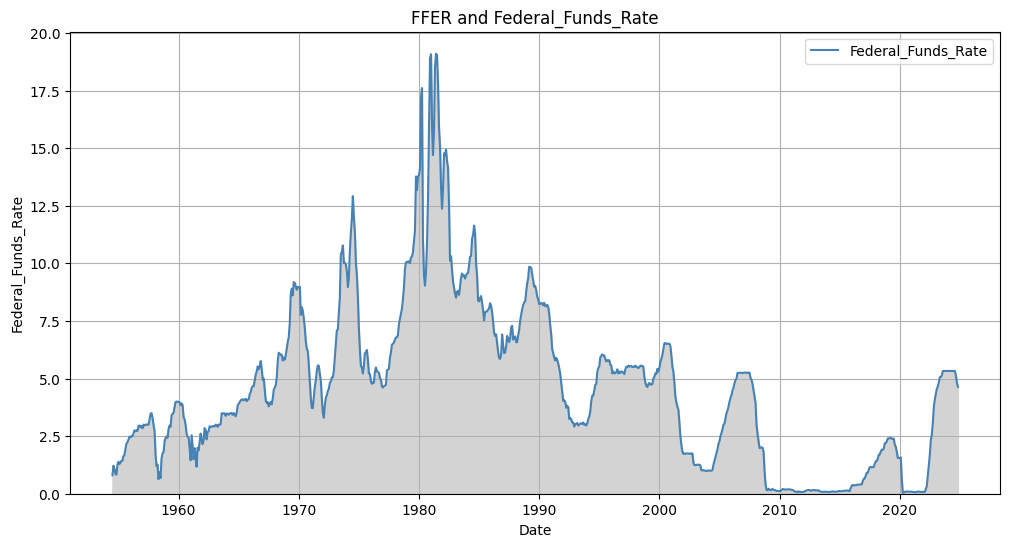

Lagged_FFR
        Date  Value
0 1954-08-01   0.80
1 1954-09-01   1.22
2 1954-10-01   1.07
3 1954-11-01   0.85
4 1954-12-01   0.83


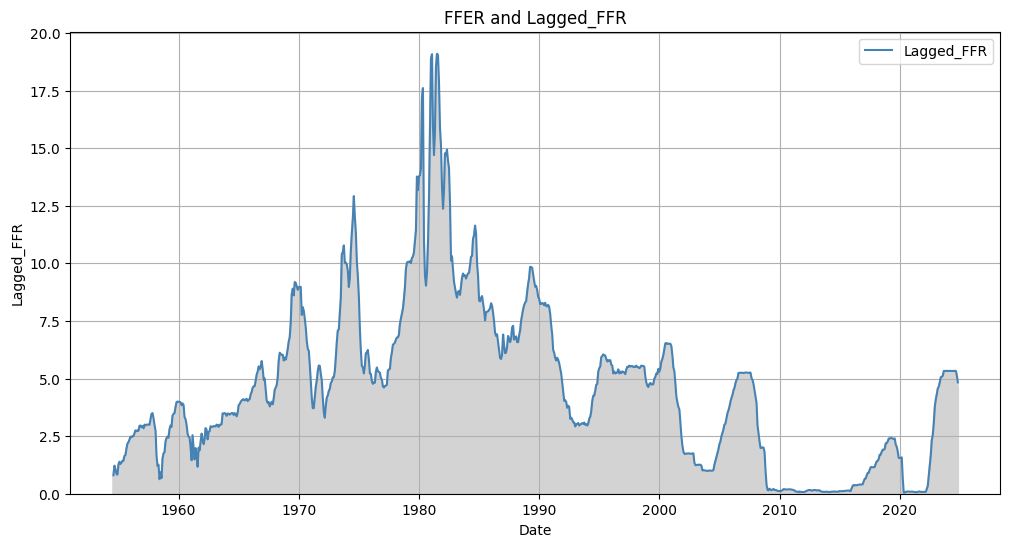

Reserve_Rate
         Date  Value
0  2008-10-09   0.75
1  2008-10-10   0.75
2  2008-10-11   0.75
3  2008-10-12   0.75
4  2008-10-13   0.75


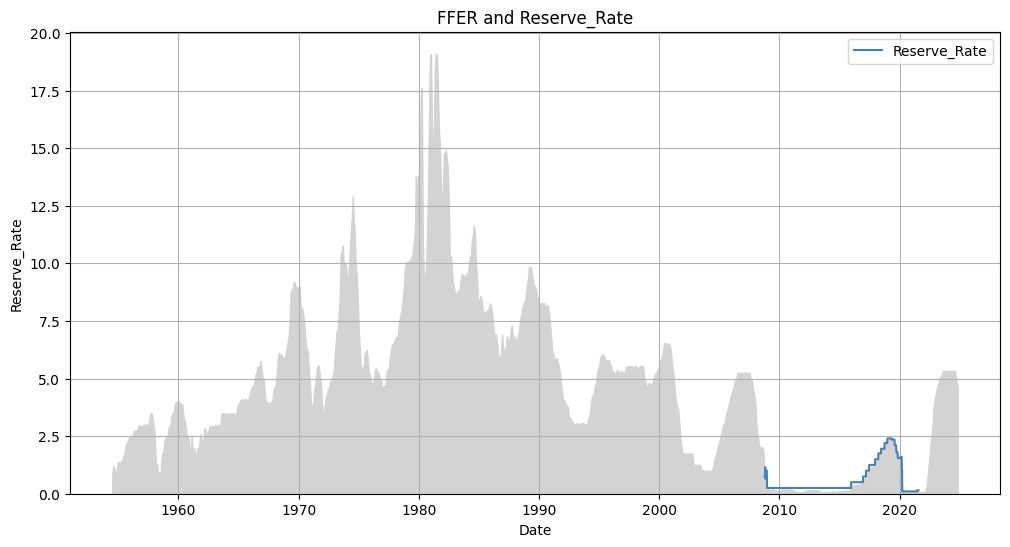

Discount_Rate
          Date  Value
54  1954-07-01    1.5
55  1954-08-01    1.5
56  1954-09-01    1.5
57  1954-10-01    1.5
58  1954-11-01    1.5


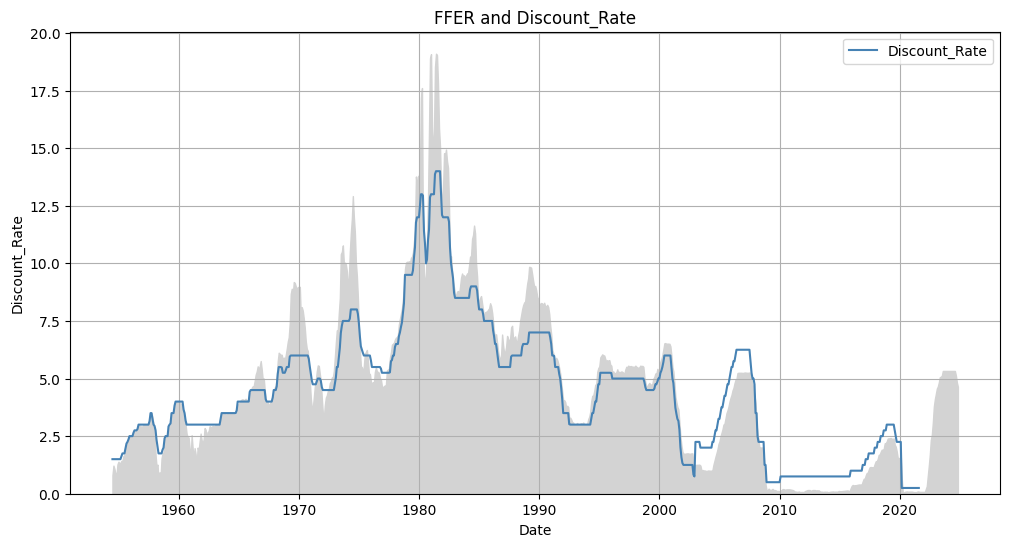

Lagged_DR
         Date  Value
53 1954-07-01    1.5
54 1954-08-01    1.5
55 1954-09-01    1.5
56 1954-10-01    1.5
57 1954-11-01    1.5


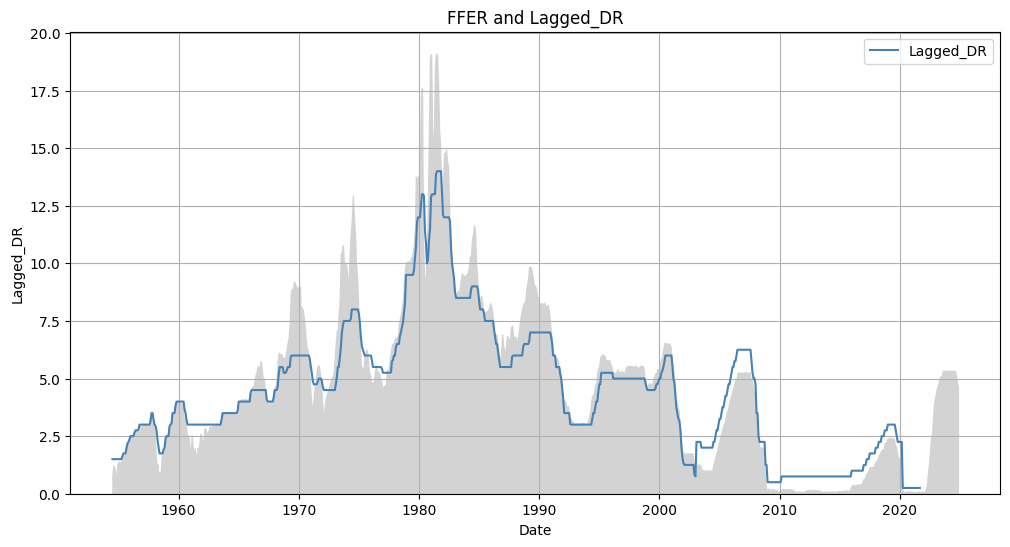

Prime_Loan_Rate
         Date  Value
0  1955-08-04   3.25
1  1955-08-05   3.25
2  1955-08-08   3.25
3  1955-08-09   3.25
4  1955-08-10   3.25


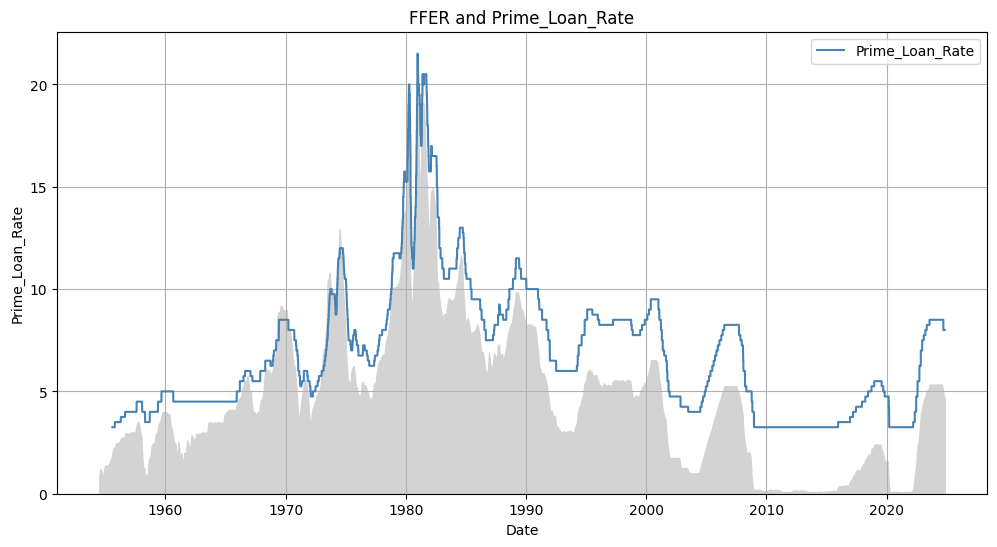

Lagged_PR
        Date  Value
0 1955-09-04   3.25
1 1955-09-05   3.25
2 1955-09-08   3.25
3 1955-09-09   3.25
4 1955-09-10   3.25


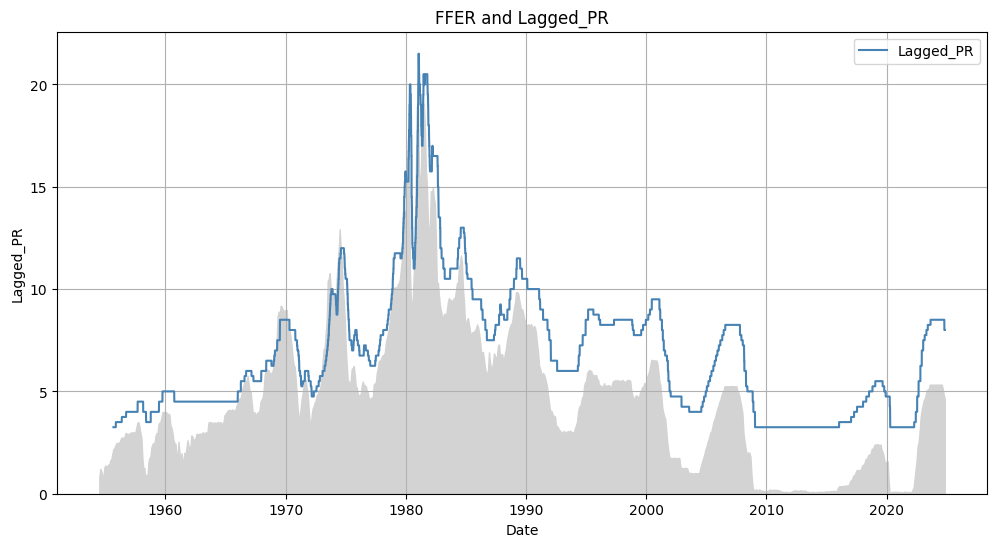

Struct_Spending
          Date  Value
43  1954-07-01    NaN
44  1954-08-01    NaN
45  1954-09-01    NaN
46  1954-10-01    NaN
47  1954-11-01    NaN


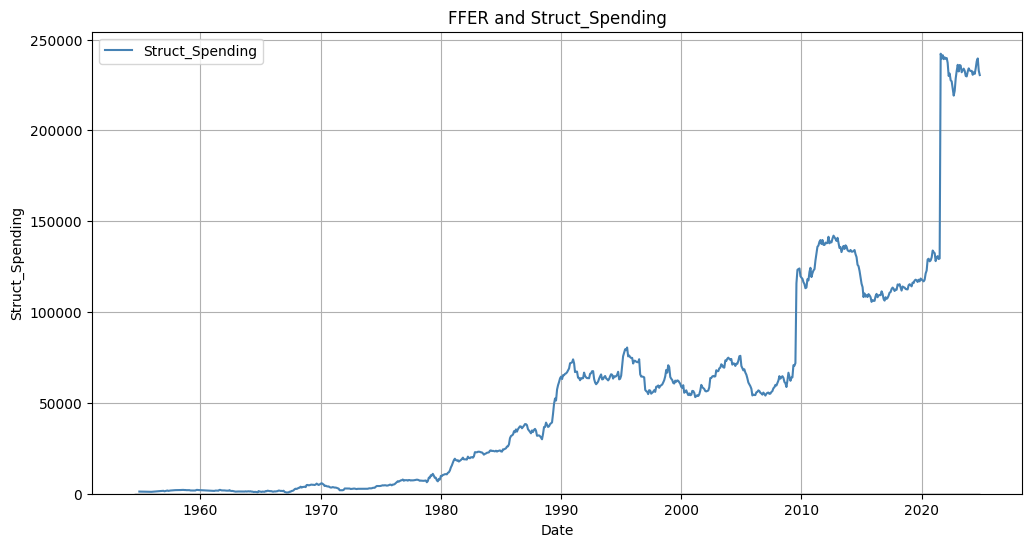

Volatility_Idx
         Date  Value
0  1990-01-02  17.24
1  1990-01-03  18.19
2  1990-01-04  19.22
3  1990-01-05  20.11
4  1990-01-08  20.26


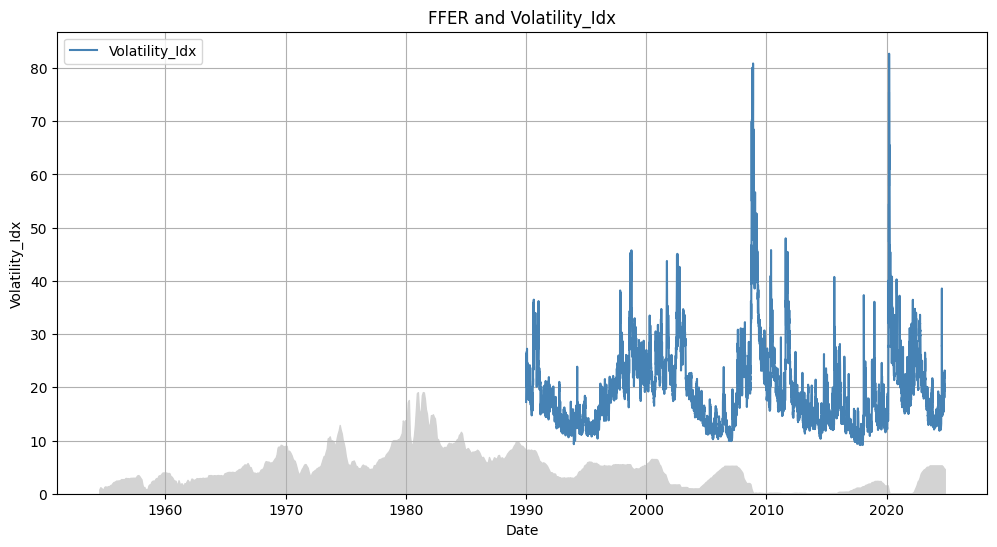

Reserves_Ex_Gold
         Date   Value
0  1993-01-01  458080
1  1993-02-01  462967
2  1993-03-01  458399
3  1993-04-01  469425
4  1993-05-01  468998


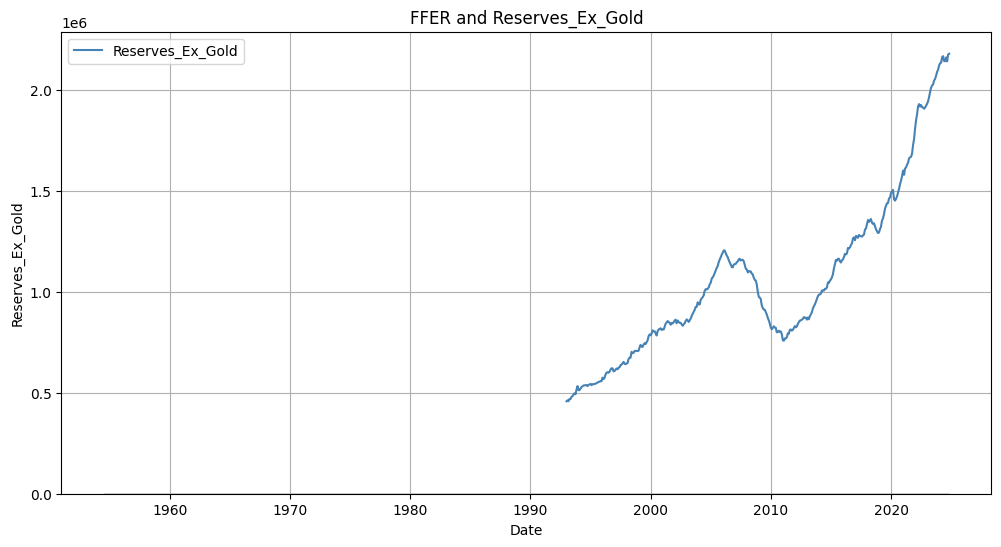

AAA_Bond_Yield
           Date  Value
426  1954-07-01   2.89
427  1954-08-01   2.87
428  1954-09-01   2.89
429  1954-10-01   2.87
430  1954-11-01   2.89


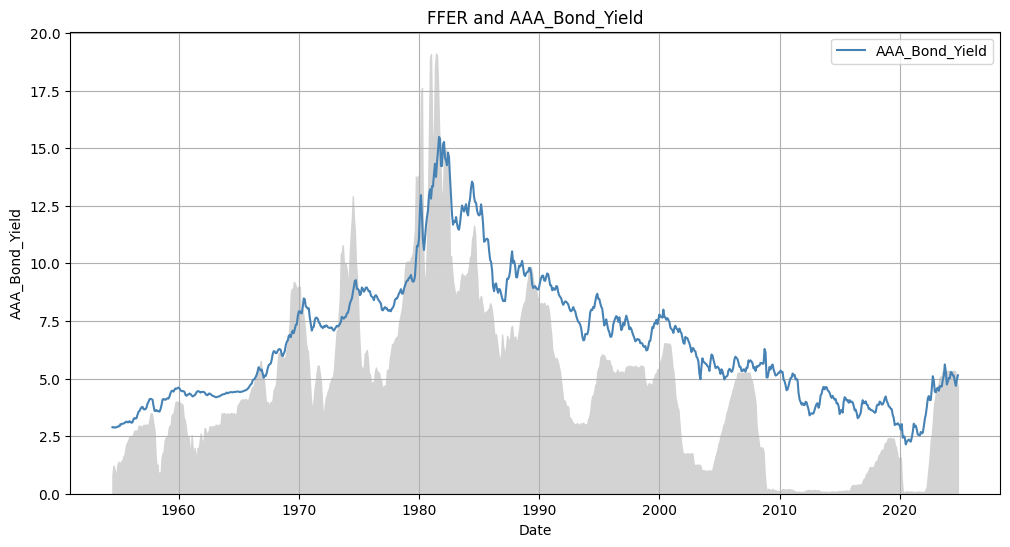

New_Orders
         Date  Value
0  1992-02-01  33857
1  1992-03-01  35258
2  1992-04-01  35992
3  1992-05-01  36811
4  1992-06-01  36666


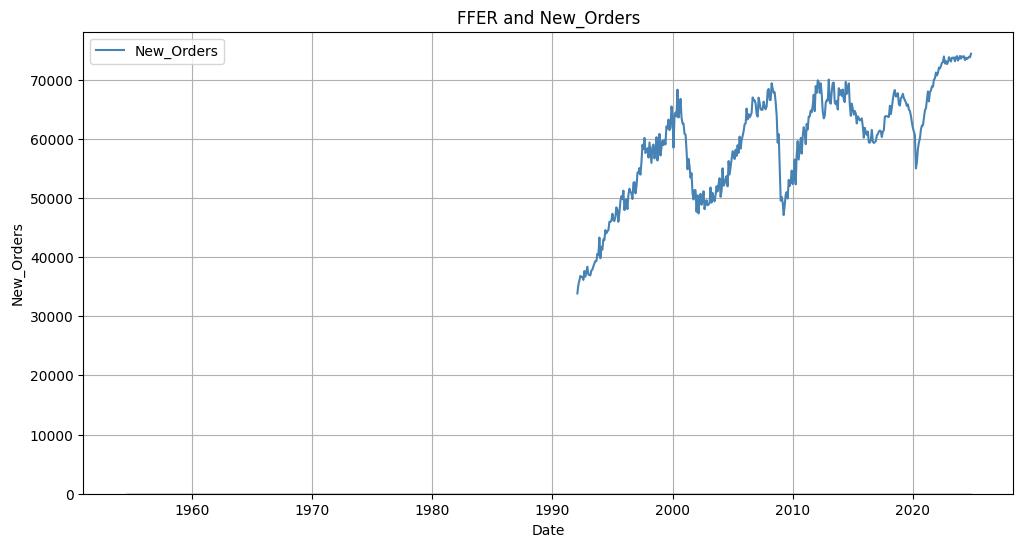

Mortgage_Rate
         Date  Value
0  1971-04-02   7.33
1  1971-04-09   7.31
2  1971-04-16   7.31
3  1971-04-23   7.31
4  1971-04-30   7.29


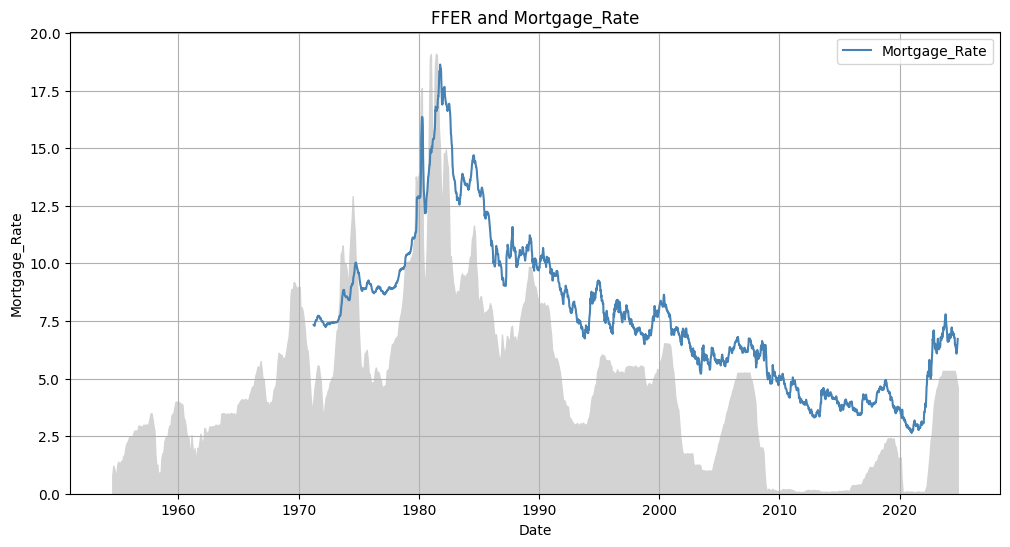

M2_Supply
         Date  Value
0  1959-01-01  286.6
1  1959-02-01  287.7
2  1959-03-01  289.2
3  1959-04-01  290.1
4  1959-05-01  292.2


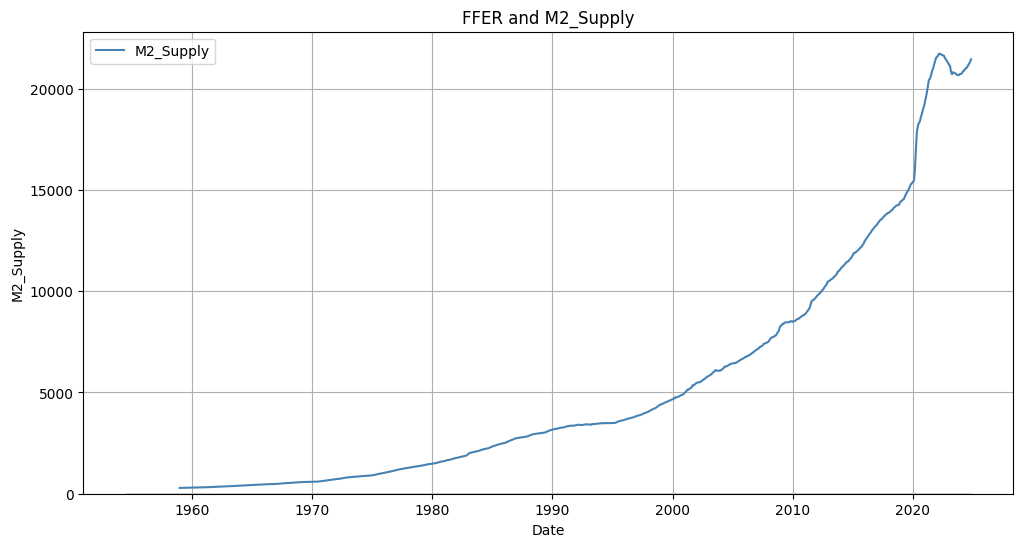

In [263]:
for label, df in clean_dfs.items():
  print(label)
  print(df.head())
  plot_comparison(ffr_data, df, 'FFER', label)


# Data Processing

In [264]:
# Add Percent Changes, and Clean Date Column
for label, df in clean_dfs.items():
    df = df_dates_monthly(df)
    df = df_change_percent(df)
    df.drop_duplicates(inplace=True)
    clean_dfs[label] = df

<ipython-input-235-22ba120149bb>:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clean_df['ChangePercentMonth'] = round(clean_df[Value].pct_change(),6)
<ipython-input-235-22ba120149bb>:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clean_df['ChangePercentYear'] = round(clean_df[Value].pct_change(12),6)
<ipython-input-235-22ba120149bb>:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  clean_df['Chan

# Export Data

In [265]:
for label, df in clean_dfs.items():
    df.to_csv(f'clean_{label}.csv', index=False)
    df.to_csv(f'clean_{label}.csv', index=False)